<a href="https://colab.research.google.com/github/stanfordnmbl/opencap-processing/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting started with analyzing OpenCap data using OpenSim API

The most recent release of OpenSim 4.4 enables users to import OpenSim into a colab notebook using Conda. This allows users to interact with the OpenSim API to perform more complex analysis in addition to simple visualization.

To learn more about using the [OpenSim Conda package](https://anaconda.org/opensim-org/opensim), please refer to these tutorials in google colab: https://github.com/opensim-org/opensim-models/tree/master/notebooks/tutorials



# Install OpenSim using condacolab

The first step is to install [condacolab](https://github.com/conda-incubator/condacolab) in your notebook. Once is this complete, you can use conda to install the OpenSim Conda package into the enviroment. 

Note, this might take a few minutes to complete.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c opensim_admin opensim


# Import the OpenCap processing source code from the GitHub repo

The source code for this example can be found on GitHub: https://github.com/stanfordnmbl/opencap-processing

Note, there are instructions in the readme of the repo with the necessary conda commands to run the example code locally on your computer via the command prompt. There are also instructions to perform muscle driven simulations and for downloading your data from OpenCap using Python.

Run the next section of code to import the GitHub repository and install the necessary Python packages.


In [ ]:
!git clone https://github.com/stanfordnmbl/opencap-processing.git
%cd /content/opencap-processing
!python3 -m pip install -r requirements.txt

If the block above runs successfully, you should see that it installed several Python packages with a message:

```
Successfully installed backcall-0.2.0 cycler-0.11.0 decorator-5.1.1 evdev-1.6.0 fonttools-4.37.4 ipython-7.34.0 jedi-0.18.1 kiwisolver-1.4.4 maskpass-0.3.6 matplotlib-3.5.3 matplotlib-inline-0.1.6 packaging-21.3 pandas-1.3.5 parso-0.8.3 pexpect-4.8.0 pickleshare-0.7.5 pillow-9.2.0 prompt-toolkit-3.0.31 ptyprocess-0.7.0 pygments-2.13.0 pynput-1.7.6 pyparsing-3.0.9 python-dateutil-2.8.2 python-decouple-3.6 python-xlib-0.31 pytz-2022.4 scipy-1.7.3 traitlets-5.4.0 typing-extensions-4.3.0 wcwidth-0.2.5.
```

#Import Packages

Now that the correct Python packages have been installed and the source code cloned to this note book, you can import packages specific to the source code (`utilsKinematics`, `utils`, and `utilsPlotting`).

Note, you will be prompted to login to OpenCap with your account. If you have not created an account, you can visit [opencap.ai](https://opencap.ai) and click "Start Recording" to create an account. This will enable you to authenticate and analyze your own data in the future.

In [ ]:
import os
import utilsKinematics
from utils import download_kinematics
from utilsPlotting import plot_dataframe


You should see a `Login successful` message. Note, you will receive a two factor authentication email from lukasz.kidzinski@gmail.com. You do not need to enter the code to perform these analyses.

#Example processing stream for analysis

This example will walk through importing data, obtaining parameters through the OpenSim API, plotting, and saving parameters for analysis. 

First, enter the session id of your OpenCap data collection. This will be used to download the data directly from OpenCap. Note, you will have needed to authenticate your account in the previous step for this to work properly.

If you have not collected data yet, we have provided a `session_id` of a public example that can be used for the rest of the tutorial.

Run the next block of code to download the data.


In [3]:


# %% User inputs.
# Specify session id; see end of url in app.opencap.ai/session/<session_id>.
session_id = "4d5c3eb1-1a59-4ea1-9178-d3634610561c" # Public example session_id is "4d5c3eb1-1a59-4ea1-9178-d3634610561c"

# Specify trial names in a list; use None to process all trials in a session.
specific_trial_names = ['walk_1_25ms', 'run_2_5ms'] # There are more trials in the session, let's look at these two only for now.

# Specify where to download the data.
data_folder = os.path.join("./Data", session_id)

# Download data.
trial_names, modelName = download_kinematics(session_id, folder=data_folder, trialNames=specific_trial_names)

#Process the data using OpenSim

Now that your data has been downloaded, you can extract kinematic parameters using OpenSim. For more details of the step by step process, please refer to the `utilsKinematics.py` code in the github repository.

For this example, we analyze trials of a person walking at 1.25 m/s and running at 2.5 m/s. For each of the trials, the code below calculates the following:
1.  coordinate values, speeds, and accelerations
2.  muscle-tendon lengths
3.  center of mass values, speeds, and accelerations.


In [4]:
# %% Process data.
kinematics, coordinates, muscle_tendon_lengths, moment_arms, center_of_mass = {}, {}, {}, {}, {}
coordinates['values'], coordinates['speeds'], coordinates['accelerations'] = {}, {}, {}
center_of_mass['values'], center_of_mass['speeds'], center_of_mass['accelerations'] = {}, {}, {}

for trial_name in trial_names:
    # Create object from class kinematics.
    kinematics[trial_name] = utilsKinematics.kinematics(data_folder, trial_name, modelName=modelName, lowpass_cutoff_frequency_for_coordinate_values=10)
    
    # Get coordinate values, speeds, and accelerations.
    coordinates['values'][trial_name] = kinematics[trial_name].get_coordinate_values(in_degrees=True) # already filtered
    coordinates['speeds'][trial_name] = kinematics[trial_name].get_coordinate_speeds(in_degrees=True, lowpass_cutoff_frequency=10)
    coordinates['accelerations'][trial_name] = kinematics[trial_name].get_coordinate_accelerations(in_degrees=True, lowpass_cutoff_frequency=10)
    
    # Get muscle-tendon lengths.
    muscle_tendon_lengths[trial_name] = kinematics[trial_name].get_muscle_tendon_lengths()
    
    # Get center of mass values, speeds, and accelerations.
    center_of_mass['values'][trial_name] = kinematics[trial_name].get_center_of_mass_values(lowpass_cutoff_frequency=10)
    center_of_mass['speeds'][trial_name] = kinematics[trial_name].get_center_of_mass_speeds(lowpass_cutoff_frequency=10)
    center_of_mass['accelerations'][trial_name] = kinematics[trial_name].get_center_of_mass_accelerations(lowpass_cutoff_frequency=10)
    

#Plotting

Now that these values are calculated, you can visualize them. For example, if you were interested in the **difference in hip and knee angular velocity during walking and running**, you can plot them together.

Run the next block of code to see the plots. 

In [ ]:
# Plot selected coordinate speeds against time.
plot_dataframe(dataframes = [coordinates['speeds'][trial_names[0]], 
                             coordinates['speeds'][trial_names[1]]],
               y = ['hip_flexion_l', 'knee_angle_l'],
               xlabel = 'Time (s)',
               ylabel = 'Angular Velocity (deg/s)',
               title = 'Joint Velocity',
               labels = [trial_names[0], trial_names[1]], xrange=[0,3.5])

As you might expect, both **hip and knee angular velocity are larger during running compared to walking**. In addition to large hip and knee angular velocity, you might also expect the center of mass accelerations to increase during running as seen in next plots.

In [ ]:
# Plot center of mass accelerations.
plot_dataframe(dataframes = [center_of_mass['accelerations'][trial_names[0]], 
                             center_of_mass['accelerations'][trial_names[1]]],
               xlabel = 'Time (s)',
               ylabel = 'Acceleration (m/${s^2}$)',
               title = 'Center of mass accelerations',
               labels = [trial_names[0], trial_names[1]], xrange=[0,3.5])


In addition to kinematic parameters, you might also expect **muscle tendon lengths to change during running vs walking**. These values were calculated using OpenSim above.

Run the next block of code to plot the muscle tendon lengths of the biceps femoris, medial gastrocnemius, and rectus femoris.

In [ ]:
# Plot muscle-tendon lengths against time.
plot_dataframe(dataframes = [muscle_tendon_lengths[trial_names[0]], 
                             muscle_tendon_lengths[trial_names[1]]],
               y = ['bflh_r', 'gasmed_r', 'recfem_r'],
               xlabel = 'Time (s)',
               ylabel = 'Length (m)',
               title = 'Muscle-tendon lengths',
               labels = [trial_names[0], trial_names[1]], xrange=[0,3.5])

#Download data to a CSV file

Now that your processing is complete, you can export the data to a CSV file for futher processing.

The next block of code creates the path and stores the coordinate speeds in a CSV file.

In [ ]:
# %% Print as csv: example.
output_csv_dir = os.path.join(data_folder, 'OpenSimData', 'Kinematics', 'Outputs') # This creates the following path for the data to be stored /content/opencap-processing/Data/4d5c3eb1-1a59-4ea1-9178-d3634610561c/OpenSimData/Kinematics/Outputs/
os.makedirs(output_csv_dir, exist_ok=True)
output_csv_path = os.path.join(output_csv_dir, 'coordinate_speeds_{}.csv'.format(trial_names[0]))
coordinates['speeds'][trial_names[0]].to_csv(output_csv_path)

The path to the file is: /content/opencap-processing/Data/4d5c3eb1-1a59-4ea1-9178-d3634610561c/OpenSimData/Kinematics/Outputs/coordinate_speeds_walk_1_25ms.csv

Use the file browser in the left panel to navigate to the file and inspect. The output CSV gives you coordinate speeds at each time frame. 



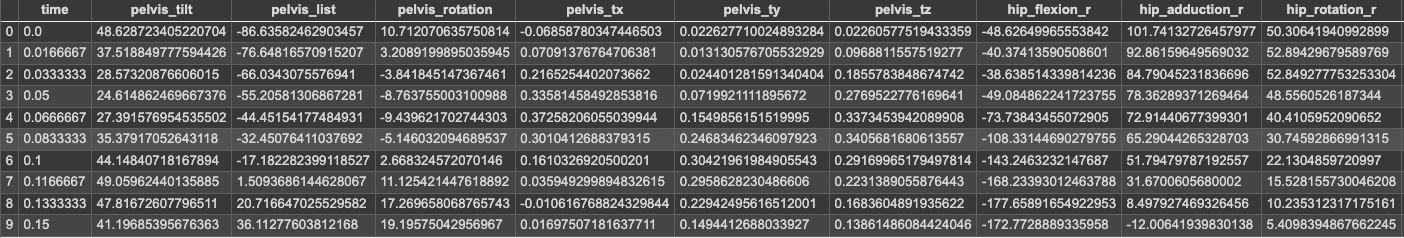

#Other Resources
> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **SimTK Website:** https://simtk.org/projects/opensim


Version 1.05

Creators: Antoine Falisse, Scott Uhlrich, Matt Petrucci.
Last Updated on September 21, 2022

This notebook is made available under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0).